# Beaching scheme comparison

In this notebook the results are produced for the analysis of the influence of the different beaching schemes.
The most important analyses consider the amount of beached particles and the difference in resulting networks

In [1]:
import numpy as np
import xarray as xr
from datetime import timedelta

import matplotlib.pyplot as plt
import cmocean
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap, Normalize

UU_colors_sec_4 = ['#f3965e','#aa1555', '#5287c6', '#5b2182']
my_cmap = ListedColormap(UU_colors_sec_4)

%matplotlib qt
foldername = '21objects'
tstep = '001'
bs = ['0','1','2','3']
flow = 'uniform'
fb = 'forward' #variable to determine whether the flowfields are analysed 'forward' or 'backward' in time
d2cmax = 0.05

Unpack all trajectory data with different beaching schemes

In [2]:
filename = flow+'.nc'
flowdata = xr.open_dataset(foldername+'/'+filename)

dfilename0 = 'B'+bs[0]+'-'+flow+'-'+tstep+'-'+fb+'.nc'
dfilename1 = 'B'+bs[1]+'-'+flow+'-'+tstep+'-'+fb+'.nc'
dfilename2 = 'B'+bs[2]+'-'+flow+'-'+tstep+'-'+fb+'.nc'
dfilename3 = 'B'+bs[3]+'-'+flow+'-'+tstep+'-'+fb+'.nc'

data0 = xr.open_dataset(foldername+'/pfiles/'+dfilename0)
data1 = xr.open_dataset(foldername+'/pfiles/'+dfilename1)
data2 = xr.open_dataset(foldername+'/pfiles/'+dfilename2)
data3 = xr.open_dataset(foldername+'/pfiles/'+dfilename3)

data = xr.concat([data0,data1,data2,data3],'bs')

outputdtlist = data0.attrs['outputdt'].split()
outputdt = timedelta(seconds=float(outputdtlist[0]))

dtlist = data0.attrs['dt'].split()
dt = timedelta(seconds=float(dtlist[0]))

runtimelist = data0.attrs['runtime'].split()
runtime = timedelta(seconds=float(runtimelist[0]))

dx  = data0.attrs['dx']
dy = dx

Define the flowfield x,y mesh coordinates and the corresponding fields and maps which enable objects-specific computations

In [3]:
objects = np.load(foldername+'/preprocessed/'+'objects.npy')
totalobjects = np.arange(22)
closestobject = np.load(foldername+'/preprocessed/'+'closestobject.npy')
coralfield = np.zeros(flowdata['U'][0,:,:].shape)
coralmesh = np.ma.masked_array(coralfield,~np.ma.masked_invalid(flowdata['U'][1,:,:]).mask)
fluidmesh = np.ma.masked_array(coralfield,np.ma.masked_invalid(flowdata['U'][1,:,:]).mask)
x,y = np.meshgrid(flowdata['X'],flowdata['Y'])
xmesh,ymesh = np.meshgrid(np.arange(flowdata['X'].values[0]-0.5*dx, flowdata['X'].values[-1]+0.5*dx, dx),
                np.arange(flowdata['Y'].values[0]+0.5*dy, flowdata['Y'].values[-1]-1.5*dy, -dy))
xob,yob = np.meshgrid(np.arange(-0.5, len(totalobjects)+0.5, 1),
                np.arange(-0.5, len(totalobjects)+0.5, 1))
xbs,ybs = np.meshgrid(np.arange(-0.5, len(bs)+0.5, 1),
                np.arange(-0.5, len(bs)+0.5, 1))

The next step in quantifying the differences between the different beaching schemes is quantifying the differences in the adjacency matrices which are the basis for all network analysis. Here we unpack all the calculated adjacency matrices in `conmatrix` and remove the self-edges in `noselfmatrix`

In [8]:
conmatrix = np.zeros((len(bs),len(totalobjects),len(totalobjects)))
noselfmatrix = np.zeros((len(bs),len(totalobjects),len(totalobjects)))
for i,beaching_strategy in enumerate(bs):
    conmatrix[i] = np.load(foldername+'/postprocessed/conmatrix-Single-Perarea-'+beaching_strategy+'-'+flow+'-'+tstep+'-'+str(d2cmax)+'.npy')
    noselfmatrix[i] = conmatrix[i]
    np.fill_diagonal(noselfmatrix[i],0)

We can caluclate the difference between all combinations of beaching strategies and plot the difference matrices to see which strategies and which objects differ the most

In [9]:
DIFF = np.zeros((len(bs),len(bs),len(totalobjects),len(totalobjects)))
for i in range(len(DIFF)):
    for j in range(len(DIFF[i])):
        DIFF[i,j] = np.absolute(noselfmatrix[i] - noselfmatrix[j])

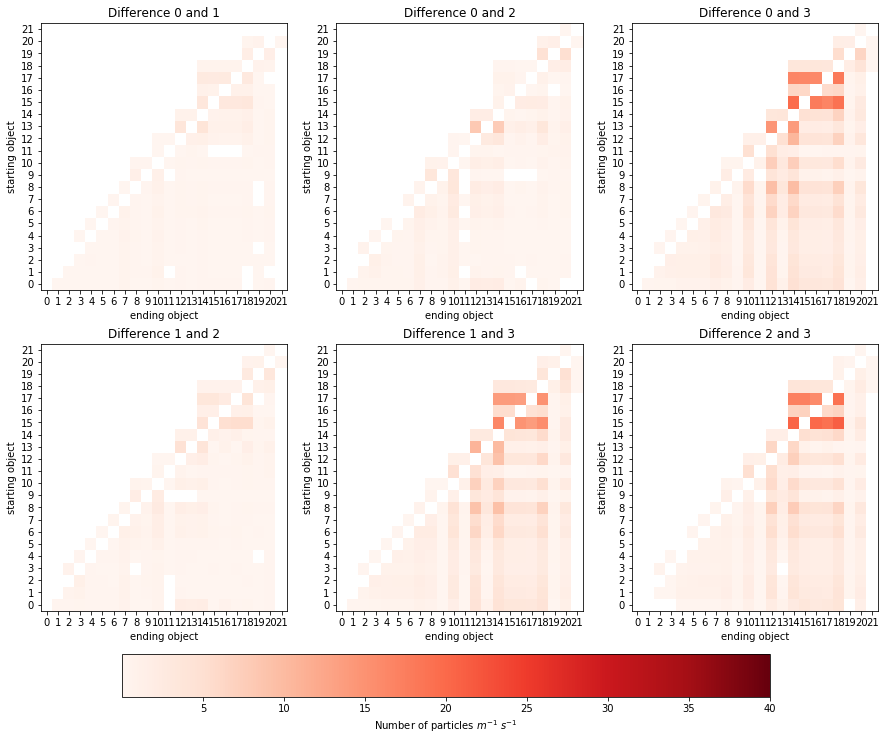

In [13]:
%matplotlib inline
colors = plt.get_cmap('Reds')
cNorm = Normalize(vmin=0.001, vmax=40)
colors.set_under('w')

fig,ax = plt.subplots(2,(len(bs)-1),figsize=(5*(len(bs)-1),12))

pc = ax[0,0].pcolormesh(xob,yob,DIFF[0,1],norm=cNorm,cmap = colors)
ax[0,0].set_title('Difference '+bs[0]+' and '+bs[1])
ax[0,0].set_xticks(np.arange(0,len(totalobjects),1))
ax[0,0].set_yticks(np.arange(0,len(totalobjects),1))
ax[0,0].set_xlabel("ending object")
ax[0,0].set_ylabel("starting object")

pc = ax[0,1].pcolormesh(xob,yob,DIFF[0,2],norm=cNorm,cmap = colors)
ax[0,1].set_title('Difference '+bs[0]+' and '+bs[2])
ax[0,1].set_xticks(np.arange(0,len(totalobjects),1))
ax[0,1].set_yticks(np.arange(0,len(totalobjects),1))
ax[0,1].set_xlabel("ending object")
ax[0,1].set_ylabel("starting object")

pc = ax[0,2].pcolormesh(xob,yob,DIFF[0,3],norm=cNorm,cmap = colors)
ax[0,2].set_title('Difference '+bs[0]+' and '+bs[3])
ax[0,2].set_xticks(np.arange(0,len(totalobjects),1))
ax[0,2].set_yticks(np.arange(0,len(totalobjects),1))
ax[0,2].set_xlabel("ending object")
ax[0,2].set_ylabel("starting object")

pc = ax[1,0].pcolormesh(xob,yob,DIFF[1,2],norm=cNorm,cmap = colors)
ax[1,0].set_title('Difference '+bs[1]+' and '+bs[2])
ax[1,0].set_xticks(np.arange(0,len(totalobjects),1))
ax[1,0].set_yticks(np.arange(0,len(totalobjects),1))
ax[1,0].set_xlabel("ending object")
ax[1,0].set_ylabel("starting object")

pc = ax[1,1].pcolormesh(xob,yob,DIFF[1,3],norm=cNorm,cmap = colors)
ax[1,1].set_title('Difference '+bs[1]+' and '+bs[3])
ax[1,1].set_xticks(np.arange(0,len(totalobjects),1))
ax[1,1].set_yticks(np.arange(0,len(totalobjects),1))
ax[1,1].set_xlabel("ending object")
ax[1,1].set_ylabel("starting object")

pc = ax[1,2].pcolormesh(xob,yob,DIFF[2,3],norm=cNorm,cmap = colors)
ax[1,2].set_title('Difference '+bs[2]+' and '+bs[3])
ax[1,2].set_xticks(np.arange(0,len(totalobjects),1))
ax[1,2].set_yticks(np.arange(0,len(totalobjects),1))
ax[1,2].set_xlabel("ending object")
ax[1,2].set_ylabel("starting object")



fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.05])
cbar = fig.colorbar(pc,orientation='horizontal',label='Number of particles $m^{-1}$ $s^{-1}$', cax=cbar_ax)
plt.savefig('Figures/diffmatrix-beachcomp')

To capture the difference in a single value, we can calculate matrix norms for the difference matrices. The Frobenius norm gives the absolute distance in the form of a vector norm and seems most suitable to determine the difference magnitude. The other results look at the maximum difference in starting and ending objects respectively

In [14]:
maxcolsum = np.zeros((len(DIFF),len(DIFF[0])))
maxrowsum = np.zeros((len(DIFF),len(DIFF[0])))
frobenius = np.zeros((len(DIFF),len(DIFF[0])))
for i in range(len(DIFF)):
    for j in range(len(DIFF[i])):
        maxcolsum[i,j] = np.amax(np.sum(np.absolute(DIFF[i,j]),axis=1))
        maxrowsum[i,j] = np.amax(np.sum(np.absolute(DIFF[i,j]),axis=0))
        frobenius[i,j] = np.sqrt(np.sum(np.square(np.absolute(DIFF[i,j]))))

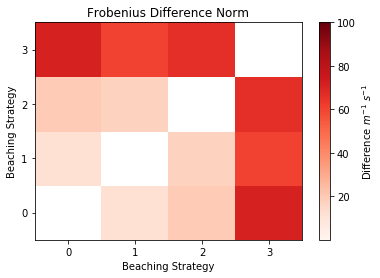

In [17]:
colors = plt.get_cmap('Reds')
cNorm = Normalize(vmin=0.001, vmax=100)
colors.set_under('w')

fig = plt.figure()
ax = plt.axes()

pc = ax.pcolormesh(xbs,ybs,frobenius,norm=cNorm,cmap = colors)
ax.set_title('Frobenius Difference Norm')
ax.set_xticks(np.arange(0,len(bs),1))
ax.set_yticks(np.arange(0,len(bs),1))
ax.set_xlabel("Beaching Strategy")
ax.set_ylabel("Beaching Strategy")

cbar = fig.colorbar(pc,label='Difference $m^{-1}$ $s^{-1}$')
plt.savefig('Figures/frobenius-perarea-beachcomp')

The final way to look at the effect of beaching is to look at the particles that do not beach in the original run and look at how different their trajectories are in the other cases. The purpose of the beaching strategies is to trace the most accurate trajectories in the fluid cells bordering the solid boundary. After looking at the amount of particles that get stuck and how the beaching affects the network result, the last effect to look at is how the trajectories differ that do not actually get stuck in the original case, i.e. that do not look to be traced incorrectly. If they differ alot, getting the scheme correct becomes more important. To start, we select all the trajectories that do not result in beaching in the original case i.e. scheme 0, find the trajectories that do not beach and save them in `Btrajs0`

In [10]:
nonbdata0 = data0.where(data0['closestobject'][:,-1]!=len(objects),drop=True)
Btrajs0 = nonbdata0['trajectory']
Btrajs0 = np.unique(Btrajs0)
Btrajs0 = Btrajs0[~np.isnan(Btrajs0)]

Now we find the same trajectories in all datasets

In [11]:
b0data0 = data0.where(data0['trajectory'].isin([Btrajs0]),drop=True)
b1data0 = data1.where(data1['trajectory'].isin([Btrajs0]),drop=True)
b2data0 = data2.where(data2['trajectory'].isin([Btrajs0]),drop=True)
b3data0 = data3.where(data3['trajectory'].isin([Btrajs0]),drop=True)

Animate all trajectories that do not beach with scheme 0

In [13]:
%matplotlib qt

fig = plt.figure(figsize=(18,4.5))
ax = plt.axes()
ax.set_facecolor('#d6fffe')
pc = ax.pcolormesh(xmesh,-ymesh,coralmesh,cmap=cmocean.cm.gray) # coral objects as background
sc3 = ax.scatter(b3data0['lon'][:,0], b3data0['z'][:,0], c=[my_cmap(3)]*len(b3data0['lon'][:,0]),s=5, marker="o",label='3', alpha = 0.7)
sc2 = ax.scatter(b2data0['lon'][:,0], b2data0['z'][:,0], c=[my_cmap(2)]*len(b2data0['lon'][:,0]),s=5, marker="o",label='2', alpha = 0.6)
sc1 = ax.scatter(b1data0['lon'][:,0], b1data0['z'][:,0], c=[my_cmap(1)]*len(b1data0['lon'][:,0]),s=5, marker="o",label='1', alpha = 0.5)
sc0 = ax.scatter(b0data0['lon'][:,0], b0data0['z'][:,0], c=[my_cmap(0)]*len(b0data0['lon'][:,0]),s=5, marker="o",label='0', alpha = 0.4)
topleft = 0.05
if fb == 'backward':
    topleft = 0.8
time_text = ax.text(topleft, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)

def animate(i,fig,sc0,sc1,sc2,sc3):
    sc3.set_offsets(np.c_[b3data0['lon'][:,i], b3data0['z'][:,i]])
    sc2.set_offsets(np.c_[b2data0['lon'][:,i], b2data0['z'][:,i]])
    sc1.set_offsets(np.c_[b1data0['lon'][:,i], b1data0['z'][:,i]])
    sc0.set_offsets(np.c_[b0data0['lon'][:,i], b0data0['z'][:,i]])
    ts = i*outputdt.microseconds/1000000
    if fb == 'b':
        ts = ts*-1
    time_text.set_text('time = %.1f seconds' % ts)
    return sc3,sc2,sc1,sc0, time_text,

ax.set_xlabel("x [m]")
ax.set_ylabel("z (m)")
ax.set_xlim(-0.5,8.5)
ax.set_ylim(-0.49,0.5)
ax.invert_yaxis()
anim = animation.FuncAnimation(fig, animate, fargs = (fig, sc0,sc1,sc2,sc3),
                               frames = len(b0data0['lon'][0]), blit=True)
plt.legend(loc=(1.01,0.75))
plt.subplots_adjust(bottom=0.1)
# anim.save('Figures/BeachingDifferenceAnimation0.mp4')
plt.show()

Calculate the euclidean differences between the trajectories for the different beaching schemes, dropping the trajectories where the difference is zero everywhere

In [14]:
dl01 = b1data0['lon'] - b0data0['lon']
dz01 = b1data0['z'] - b0data0['z']
dist01 = np.sqrt(np.square(dl01) + np.square(dz01))
dist01 = dist01.where(dist01>0,drop=True)
meand01 = np.mean(dist01,axis=0)

In [15]:
dl02 = b2data0['lon'] - b0data0['lon']
dz02 = b2data0['z'] - b0data0['z']
dist02 = np.sqrt(np.square(dl02) + np.square(dz02))
dist02 = dist02.where(dist02>0,drop=True)
meand02 = np.mean(dist02,axis=0)

In [16]:
dl03 = b3data0['lon'] - b0data0['lon']
dz03 = b3data0['z'] - b0data0['z']
dist03 = np.sqrt(np.square(dl03) + np.square(dz03))
dist03 = dist03.where(dist03>0,drop=True)
meand03 = np.mean(dist03,axis=0)

In [17]:
fig = plt.figure()
ax =plt.axes()
ax.plot(dist01.transpose(),c='gray',alpha=0.2)
ax.plot(meand01,c=my_cmap(1),linewidth=3, label = 'Mean of all differing trajectories')
ax.text(0.01,0.95,'Differing/Total non-beaching trajectories : '+str(len(dist01['traj']))+'/'+str(len(b0data0['traj']))+' = '+str(np.round(len(dist01['traj'])/len(b0data0['traj'])*100,2))+'%', transform=ax.transAxes)
ax.set_ylabel('Euclidean Distance [m]')
ax.set_xlabel('Time [s]')
ax.set_title('Differing trajectories schemes 0 and 1')
ax.set_ylim(0,8)
plt.legend(loc=(0.01,0.85))
# plt.savefig('Figures/diff01')

In [18]:
fig = plt.figure()
ax =plt.axes()
ax.plot(dist02.transpose(),c='gray',alpha=0.2)
ax.plot(meand02,c=my_cmap(2),linewidth=3, label = 'Mean of all differing trajectories')
ax.text(0.01,0.95,'Differing/Total non-beaching trajectories : '+str(len(dist02['traj']))+'/'+str(len(b0data0['traj']))+' = '+str(np.round(len(dist02['traj'])/len(b0data0['traj'])*100,2))+'%', transform=ax.transAxes)
ax.set_ylabel('Euclidean Distance [m]')
ax.set_xlabel('Time [s]')
ax.set_title('Differing trajectories schemes 0 and 2')
ax.set_ylim(0,8)
plt.legend(loc=(0.01,0.85))
# plt.savefig('Figures/diff02')

In [19]:
fig = plt.figure()
ax =plt.axes()
ax.plot(dist03.transpose(),c='gray',alpha=0.2)
ax.plot(meand03,c=my_cmap(3),linewidth=3, label = 'Mean of all differing trajectories')
ax.text(0.01,0.95,'Differing/Total non-beaching trajectories : '+str(len(dist03['traj']))+'/'+str(len(b0data0['traj']))+' = '+str(np.round(len(dist03['traj'])/len(b0data0['traj'])*100,2))+'%', transform=ax.transAxes)
ax.set_ylabel('Euclidean Distance [m]')
ax.set_xlabel('Time [s]')
ax.set_title('Differing trajectories schemes 0 and 3')
ax.set_ylim(0,8)
plt.legend(loc=(0.01,0.85))
# plt.savefig('Figures/diff03')

Now we can do the same by comparing beaching schemes 2 and 3 to scheme 1, where the boundaries are 'seen' at the correct location.

In [20]:
nonbdata1 = data1.where(data1['closestobject'][:,-1]!=len(objects),drop=True)
Btrajs1 = nonbdata1['trajectory']
Btrajs1 = np.unique(Btrajs1)
Btrajs1 = Btrajs1[~np.isnan(Btrajs1)]

In [21]:
b1data1 = data1.where(data1['trajectory'].isin([Btrajs1]),drop=True)
b2data1 = data2.where(data2['trajectory'].isin([Btrajs1]),drop=True)
b3data1 = data3.where(data3['trajectory'].isin([Btrajs1]),drop=True)

In [22]:
fig = plt.figure(figsize=(18,4.5))
ax = plt.axes()
ax.set_facecolor('#d6fffe')
pc = ax.pcolormesh(xmesh,-ymesh,coralmesh,cmap=cmocean.cm.gray) # coral objects as background
sc3 = ax.scatter(b3data1['lon'][:,0], b3data1['z'][:,0], c=[my_cmap(3)]*len(b3data1['lon'][:,0]),s=5, marker="o",label='3', alpha = 0.7)
sc2 = ax.scatter(b2data1['lon'][:,0], b2data1['z'][:,0], c=[my_cmap(2)]*len(b2data1['lon'][:,0]),s=5, marker="o",label='2', alpha = 0.6)
sc1 = ax.scatter(b1data1['lon'][:,0], b1data1['z'][:,0], c=[my_cmap(1)]*len(b1data1['lon'][:,0]),s=5, marker="o",label='1', alpha = 0.4)
topleft = 0.05
if fb == 'backward':
    topleft = 0.8
time_text = ax.text(topleft, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)

def animate(i,fig,sc1,sc2,sc3):
    sc3.set_offsets(np.c_[b3data1['lon'][:,i], b3data1['z'][:,i]])
    sc2.set_offsets(np.c_[b2data1['lon'][:,i], b2data1['z'][:,i]])
    sc1.set_offsets(np.c_[b1data1['lon'][:,i], b1data1['z'][:,i]])
    ts = i*outputdt.microseconds/1000000
    if fb == 'b':
        ts = ts*-1
    time_text.set_text('time = %.1f seconds' % ts)
    return sc3,sc2,sc1,sc0, time_text,

ax.set_xlabel("x [m]")
ax.set_ylabel("z (m)")
ax.set_xlim(-0.5,8.5)
ax.set_ylim(-0.49,0.5)
ax.invert_yaxis()
anim = animation.FuncAnimation(fig, animate, fargs = (fig,sc1,sc2,sc3),
                               frames = len(b1data1['lon'][0]), blit=True)
plt.legend(loc=(1.01,0.75))
plt.subplots_adjust(bottom=0.1)
# anim.save('Figures/BeachingDifferenceAnimation1.mp4')
plt.show()

In [23]:
dl12 = b2data1['lon'] - b1data1['lon']
dz12 = b2data1['z'] - b1data1['z']
dist12 = np.sqrt(np.square(dl12) + np.square(dz12))
dist12 = dist12.where(dist12>0,drop=True)
meand12 = np.mean(dist12,axis=0)

In [24]:
dl13 = b3data1['lon'] - b1data1['lon']
dz13 = b3data1['z'] - b1data1['z']
dist13 = np.sqrt(np.square(dl13) + np.square(dz13))
dist13 = dist13.where(dist13>0,drop=True)
meand13 = np.mean(dist13,axis=0)

In [25]:
fig = plt.figure()
ax =plt.axes()
ax.plot(dist12.transpose(),c='gray',alpha=0.2)
ax.plot(meand12,c=my_cmap(2),linewidth=3, label = 'Mean of all differing trajectories')
ax.text(0.01,0.95,'Differing/Total non-beaching trajectories : '+str(len(dist12['traj']))+'/'+str(len(b1data1['traj']))+' = '+str(np.round(len(dist12['traj'])/len(b1data1['traj'])*100,2))+'%', transform=ax.transAxes)
ax.set_ylabel('Euclidean Distance [m]')
ax.set_xlabel('Time [s]')
ax.set_title('Differing trajectories schemes 1 and 2')
ax.set_ylim(0,8)
plt.legend(loc=(0.01,0.85))
# plt.savefig('Figures/diff12')

In [26]:
fig = plt.figure()
ax =plt.axes()
ax.plot(dist13.transpose(),c='gray',alpha=0.2)
ax.plot(meand13,c=my_cmap(3),linewidth=3, label = 'Mean of all differing trajectories')
ax.text(0.01,0.95,'Differing/Total non-beaching trajectories : '+str(len(dist13['traj']))+'/'+str(len(b1data1['traj']))+' = '+str(np.round(len(dist13['traj'])/len(b1data1['traj'])*100,2))+'%', transform=ax.transAxes)
ax.set_ylabel('Euclidean Distance [m]')
ax.set_xlabel('Time [s]')
ax.set_title('Differing trajectories schemes 1 and 3')
ax.set_ylim(0,8)
plt.legend(loc=(0.01,0.85))
# plt.savefig('Figures/diff13')